# Thème 4 – Le vélo au service des espaces du quotidien
**Analyse carto :** Croisement base d’équipement INSEE et point rouge baromètre 
- Identifier le % de point rouge à – de 50 m d’un établissement d’enseignement, de santé et de commerces  

> L’accessibilité aux communes pourvoyeuses de services et d’équipements est encore trop complexe en France 


## Python stuff

In [1]:
import textwrap
import pandas as pd
import geopandas as gpd
from s3_utils import S3Manager
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact

_ = plt.style.use("ggplot")

In [2]:
# Chargement des éléments de connexion sur S3
s3_manager = S3Manager()
bucket = "fub-s3"

## 1 - Récupération et préparation des données

In [3]:
# Import des données sources
gdf = s3_manager.load_geojson_from_s3(bucket, "data/DFG/2025/data_geo/données-carto-2025-06-03.geojson")
print(gdf.crs)
gdf.head(2)

✅ Fichier chargé et converti en GeoDataFrame avec succès
EPSG:4326


,uid,cat,uid_reponse,description,geometry
0,dd441ba7-d3a7-490e-8cfe-1d34e4a09311,58,ffde2d2e-fa32-4bbb-a7f2-f94300dfb19d,Route trop étroite et dangereuse,POINT (4.47109 47.1244)
1,63ef8e40-8be8-4362-b9ea-5b38a0347ef3,59,ffde2d2e-fa32-4bbb-a7f2-f94300dfb19d,Maison de santé,POINT (4.48483 47.13117)


In [4]:
url_contour_france = "https://france-geojson.gregoiredavid.fr/repo/departements.geojson"
contour_france = gpd.read_file(url_contour_france)

In [5]:
gdf = gdf.to_crs(contour_france.crs)
gdf_filtre = gpd.sjoin(gdf, contour_france, predicate="within", how="inner")
gdf_filtre = gdf_filtre.drop(columns=["index_right"])

In [6]:
# Import des données d'enrichissements depuis S3
s3_manager.download_from_s3(
    bucket, 
    "data/DFG/2025/data_geo/externe/4C-buildingref-france-bpe-all-geolocated.fgb", 
    "temp/buildingref-france-bpe-all-geolocated.fgb"
)
equipements = gpd.read_file("temp/buildingref-france-bpe-all-geolocated.fgb")
print(equipements.crs)
equipements.head(2)

✅ Fichier téléchargé depuis S3 : temp/buildingref-france-bpe-all-geolocated.fgb
EPSG:4326


,reg_code,dep_code,com_arm_code,iris_code,year,equipment_code,geocode_quality,equipment_name,category,reg_name,dep_name,epci_name,com_arm_name,com_arm_area_code,epci_code,geometry
0,93,13,13026,130260104,NaT,D603,Acceptable,ADULTES HANDICAPÉS : ACCUEIL/HÉBERGEMENT,Santé,Provence-Alpes-Côte d'Azur,Bouches-du-Rhône,Métropole d'Aix-Marseille-Provence,Châteauneuf-les-Martigues,FXX,200054807,POINT (5.14153 43.39474)
1,93,83,83049,830490102,NaT,D603,Bonne,ADULTES HANDICAPÉS : ACCUEIL/HÉBERGEMENT,Santé,Provence-Alpes-Côte d'Azur,Var,CC Méditerranée Porte des Maures,Cuers,FXX,200027100,POINT (6.08587 43.25823)


In [7]:
url_contour_france = "https://france-geojson.gregoiredavid.fr/repo/departements.geojson"
contour_france = gpd.read_file(url_contour_france)

In [8]:
equipements = equipements.to_crs(contour_france.crs)
equipements = gpd.sjoin(equipements, contour_france, predicate="within", how="inner")
equipements = equipements.drop(columns=["index_right", "code", "nom"])

In [9]:
equipements = equipements[[
    'equipment_name', 'category', 'com_arm_name', 'geometry'
]].copy()

In [10]:
equipements.groupby('com_arm_name').size().reset_index(name="Nombre d'équipement").sort_values(by="Nombre d'équipement", ascending=False).head(10)

,com_arm_name,Nombre d'équipement
21405,Toulouse,6074
14425,Nice,5301
2523,Bordeaux,4082
13665,Montpellier,3853
20856,Strasbourg,3495
14229,Nantes,3467
15172,Paris 15e Arrondissement,3161
15173,Paris 16e Arrondissement,2966
11556,Lille,2957
15174,Paris 17e Arrondissement,2793


## 2 - Identifier le % de point rouge à – de 50 m d’un établissement d’enseignement, de santé et de commerces

### 2.1 - Statistique

In [11]:
# Reprojection spatiale
gdf_2154 = gdf_filtre.to_crs(2154)
equipements_2154 = equipements.to_crs(2154)

In [12]:
prox_equip = gpd.sjoin_nearest(
    gdf_2154,
    equipements_2154,
    how="left",
    max_distance=50,
    lsuffix="velo",
    rsuffix="equipement",
    distance_col="dist_m"
)
prox_equip_e = prox_equip.copy()

In [13]:
print(f"Nombre de point rouge : {gdf_2154[gdf_2154['cat'] == 58].shape[0]}")
prox_58 = prox_equip_e.loc[
        (prox_equip_e["cat"] == 58) &
        prox_equip_e["index_equipement"].notnull()
].shape[0]
print(f"Nombre de point rouge à moins de 50m d'un équipement : {prox_58}")
pct_points_couverts = 100 * prox_58 / gdf_2154[gdf_2154['cat'] == 58].shape[0]
print(f"Pourcentage de point rouge à moins de 50m d'un équipement : {pct_points_couverts:.2f}%")

Nombre de point rouge : 578073
Nombre de point rouge à moins de 50m d'un équipement : 248273
Pourcentage de point rouge à moins de 50m d'un équipement : 42.95%


### 2.2 - Test d'hypothèse

In [14]:
n58_total     = gdf_2154[gdf_2154["cat"] == 58].shape[0]
n58_covered   = prox_equip_e.loc[
                  (prox_equip_e["cat"] == 58) &
                  prox_equip_e["index_equipement"].notnull()
               ].shape[0]
n58_notcov    = n58_total - n58_covered

In [15]:
nrest_total   = gdf_2154[gdf_2154["cat"] != 58].shape[0]
nrest_covered = prox_equip_e.loc[
                  (prox_equip_e["cat"] != 58) &
                  prox_equip_e["index_equipement"].notnull()
               ].shape[0]
nrest_notcov  = nrest_total - nrest_covered

In [16]:
table = [[n58_covered,   n58_notcov],
         [nrest_covered, nrest_notcov]]

In [17]:
odds, p = fisher_exact(table, alternative="two-sided")
print(table)
print(f"Odds-ratio : {odds:.3f}")
print(f"p-value    : {p:.4g}")

[[248273, 329800], [287259, 241775]]
Odds-ratio : 0.634
p-value    : 0


### 2.3 - Déclinaison par catégories

In [18]:
prox_equip_c = prox_equip_e[
    (prox_equip_e["cat"] == 58) &
    prox_equip_e["index_equipement"].notnull()
]
print(prox_equip_c.columns)
prox_equip_c.head(2)

Index(['uid', 'cat', 'uid_reponse', 'description', 'geometry', 'code', 'nom',
       'index_equipement', 'equipment_name', 'category', 'com_arm_name',
       'dist_m'],
      dtype='object')


,uid,cat,uid_reponse,description,geometry,code,nom,index_equipement,equipment_name,category,com_arm_name,dist_m
4,384f138d-551f-48cb-a8e6-7545a3486eed,58,9ead1f87-7e1e-4c88-8044-567f871bca5d,pas de piste cyclable ; stationnement de voitu...,POINT (704965.204 7056489.714),59,Nord,282473.0,MASSEUR KINÉSITHÉRAPEUTE,Santé,Faches-Thumesnil,43.798393
6,ecabf7ab-93a8-4681-9937-8afe5d00f60c,58,9ead1f87-7e1e-4c88-8044-567f871bca5d,Pas de piste cyclable sur le croisement,POINT (705053.903 7056639.366),59,Nord,668506.0,ÉPICERIE,Commerces,Faches-Thumesnil,22.035585


In [19]:
prox_equip_cn = prox_equip_c[
    ['uid', 'description', 'geometry', 'index_equipement', 'equipment_name', 'category', 'com_arm_name']
].copy()
prox_equip_cn.head(2)

,uid,description,geometry,index_equipement,equipment_name,category,com_arm_name
4,384f138d-551f-48cb-a8e6-7545a3486eed,pas de piste cyclable ; stationnement de voitu...,POINT (704965.204 7056489.714),282473.0,MASSEUR KINÉSITHÉRAPEUTE,Santé,Faches-Thumesnil
6,ecabf7ab-93a8-4681-9937-8afe5d00f60c,Pas de piste cyclable sur le croisement,POINT (705053.903 7056639.366),668506.0,ÉPICERIE,Commerces,Faches-Thumesnil


In [20]:
prox_equip_nb = (
    prox_equip_cn.groupby("category")
    .size()
    .reset_index(name="nb_par_categorie")
)
prox_equip_nb

,category,nb_par_categorie
0,Commerces,104288
1,Enseignement,13267
2,Santé,130718


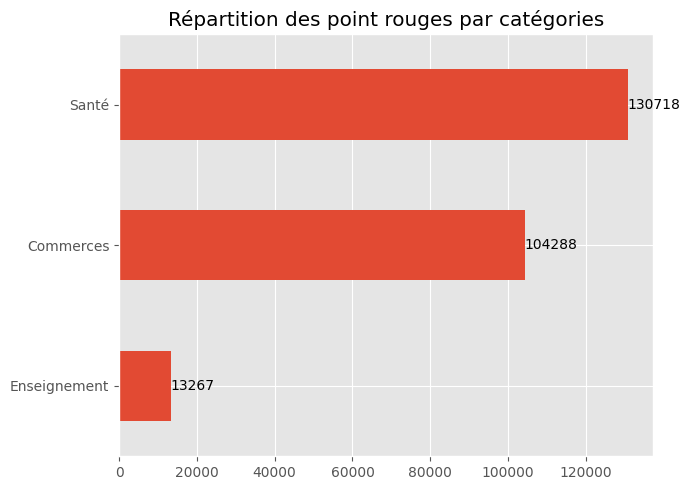

In [21]:
# Afficher les graphiques
ax = prox_equip_nb.set_index("category").sort_values(
    by="nb_par_categorie", ascending=True
    ).plot(kind="barh", figsize=(7, 5))
plt.title("Répartition des point rouges par catégories")
plt.legend().remove()
plt.ylabel("")

# Afficher les chiffres
for i in ax.patches:
    ax.text(i.get_width() + 5,
            i.get_y() + i.get_height()/2,
            int(i.get_width()),
            va='center')

plt.tight_layout()
plt.show()

In [22]:
prox_equip_nom = (
    prox_equip_cn.groupby("equipment_name")
    .size()
    .reset_index(name="nb_par_equip_name")
)
prox_equip_nom.sort_values(by="nb_par_equip_name", ascending=False).head(3)

,equipment_name,nb_par_equip_name
10,BOULANGERIE,16948
49,MAGASIN DE VÊTEMENTS,14530
64,PHARMACIE,13192


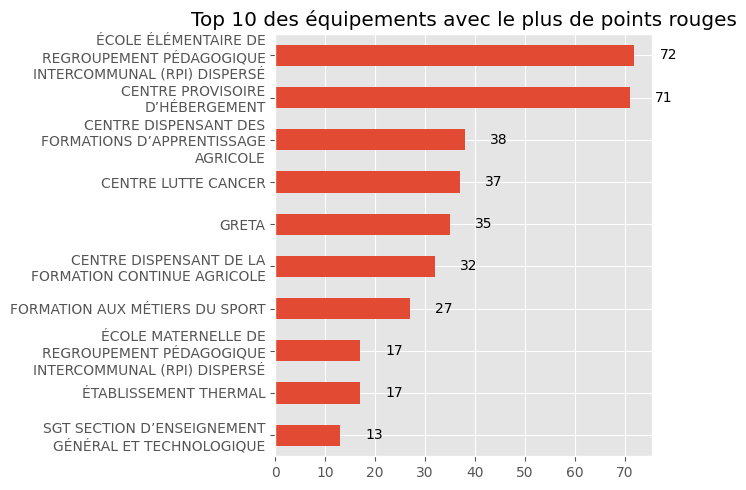

In [23]:
# Plot
ax = prox_equip_nom.set_index("equipment_name").sort_values(
    by="nb_par_equip_name", 
    ascending=True
).head(10).plot(kind="barh", figsize=(7, 5))

plt.title("Top 10 des équipements avec le plus de points rouges")
plt.legend().remove()
plt.ylabel("")

# Appliquer un retour à la ligne automatique sur les labels Y
labels = [ '\n'.join(textwrap.wrap(l.get_text(), 30)) for l in ax.get_yticklabels() ]
ax.set_yticklabels(labels)

# Afficher les chiffres
for i in ax.patches:
    ax.text(i.get_width() + 5,
            i.get_y() + i.get_height()/2,
            int(i.get_width()),
            va='center')

plt.tight_layout()
plt.show()

## 3 - Conclusion

L’analyse spatiale révèle que seuls 42,95 % des points rouges (lieux problématiques identifiés par le baromètre vélo) se situent à moins de 50 m d’un établissement d’enseignement, de santé ou de commerce, contre une proportion significativement plus élevée pour les autres points (test exact de Fisher, OR = 0,63, p < 0,001).
Ces résultats montrent que les zones jugées les plus problématiques pour les cyclistes se trouvent, en moyenne, plus éloignées des services et équipements du quotidien.

## 4 - Export des données 

### 4.1 - Données geojson

In [24]:
prox_equip_export = prox_equip_e[prox_equip_e["index_equipement"].notnull()]
prox_equip_export.head()

,uid,cat,uid_reponse,description,geometry,code,nom,index_equipement,equipment_name,category,com_arm_name,dist_m
2,899273c7-bdec-4e6b-a7bb-f81dd8b2e2cf,59,ffde2d2e-fa32-4bbb-a7f2-f94300dfb19d,Centre social,POINT (813037.998 6671132.784),21,Côte-d'Or,644974.0,INFIRMIER,Santé,Arnay-le-Duc,13.333460
3,7818ede4-4bc5-4681-b603-d9799ee57ba9,59,ffde2d2e-fa32-4bbb-a7f2-f94300dfb19d,Centre ville,POINT (812646.993 6671095.585),21,Côte-d'Or,182939.0,MAGASIN D’OPTIQUE,Commerces,Arnay-le-Duc,16.738308
4,384f138d-551f-48cb-a8e6-7545a3486eed,58,9ead1f87-7e1e-4c88-8044-567f871bca5d,pas de piste cyclable ; stationnement de voitu...,POINT (704965.204 7056489.714),59,Nord,282473.0,MASSEUR KINÉSITHÉRAPEUTE,Santé,Faches-Thumesnil,43.798393
6,ecabf7ab-93a8-4681-9937-8afe5d00f60c,58,9ead1f87-7e1e-4c88-8044-567f871bca5d,Pas de piste cyclable sur le croisement,POINT (705053.903 7056639.366),59,Nord,668506.0,ÉPICERIE,Commerces,Faches-Thumesnil,22.035585
7,88add75a-a1c3-4b27-8ba1-2e9a3b6e74fd,59,9ead1f87-7e1e-4c88-8044-567f871bca5d,None,POINT (704628.317 7056777.321),59,Nord,55073.0,FLEURISTE-JARDINERIE-ANIMALERIE,Commerces,Faches-Thumesnil,14.410680


In [25]:
prox_equip_export[prox_equip_export["com_arm_name"].str.contains("Paris")]

,uid,cat,uid_reponse,description,geometry,code,nom,index_equipement,equipment_name,category,com_arm_name,dist_m
709,b081357f-dbc2-4329-951a-6c7aa3b88093,58,4954d2a0-7e3a-4ce6-baca-bd9615efbc83,entre richelieu drouot et madeleine,POINT (651040.241 6863572.96),75,Paris,510700.0,MAGASIN D’ÉQUIPEMENTS DU FOYER,Commerces,Paris 2e Arrondissement,30.258983
709,b081357f-dbc2-4329-951a-6c7aa3b88093,58,4954d2a0-7e3a-4ce6-baca-bd9615efbc83,entre richelieu drouot et madeleine,POINT (651040.241 6863572.96),75,Paris,106227.0,HORLOGERIE-BIJOUTERIE,Commerces,Paris 2e Arrondissement,30.258983
710,96af0a27-7409-4d26-bf96-77a18453f114,58,4954d2a0-7e3a-4ce6-baca-bd9615efbc83,entre republique et grands boulevards,POINT (652522.477 6863496.437),75,Paris,95063.0,MAGASIN D’OPTIQUE,Commerces,Paris 10e Arrondissement,22.165226
711,7b63a8ee-c225-49be-8cef-87c4b3a6adfe,58,4954d2a0-7e3a-4ce6-baca-bd9615efbc83,,POINT (653356.176 6863220.06),75,Paris,577391.0,"LIBRAIRIE,PAPETERIE,JOURNAUX",Commerces,Paris 11e Arrondissement,49.487422
715,ad8bebd5-b1ac-4d87-8041-6d9cfcd541ba,60,4954d2a0-7e3a-4ce6-baca-bd9615efbc83,,POINT (656287.813 6862870.406),75,Paris,669981.0,PRODUITS SURGELÉS,Commerces,Paris 20e Arrondissement,44.013765
...,...,...,...,...,...,...,...,...,...,...,...,...
1123421,432797ad-c369-45ca-b83c-79707eb30c77,59,78d25a80-d888-4724-954d-22616b5b1925,gare de lyon c'est un enfer pour passer dessus...,POINT (654027.372 6860683.762),75,Paris,116858.0,MAGASIN D’ÉQUIPEMENTS DU FOYER,Commerces,Paris 12e Arrondissement,23.247368
1123421,432797ad-c369-45ca-b83c-79707eb30c77,59,78d25a80-d888-4724-954d-22616b5b1925,gare de lyon c'est un enfer pour passer dessus...,POINT (654027.372 6860683.762),75,Paris,194782.0,"LIBRAIRIE,PAPETERIE,JOURNAUX",Commerces,Paris 12e Arrondissement,23.247368
1123421,432797ad-c369-45ca-b83c-79707eb30c77,59,78d25a80-d888-4724-954d-22616b5b1925,gare de lyon c'est un enfer pour passer dessus...,POINT (654027.372 6860683.762),75,Paris,274421.0,BOULANGERIE,Commerces,Paris 12e Arrondissement,23.247368
1123421,432797ad-c369-45ca-b83c-79707eb30c77,59,78d25a80-d888-4724-954d-22616b5b1925,gare de lyon c'est un enfer pour passer dessus...,POINT (654027.372 6860683.762),75,Paris,26745.0,MAGASIN DE VÊTEMENTS,Commerces,Paris 12e Arrondissement,23.247368


In [26]:
prox_export = prox_equip_export.to_crs(epsg=4326) # conversion en WGS84 pour le web
prox_export.to_file("temp/points_proximite_equipements_par_categorie.geojson", driver="GeoJSON")

### 4.2 - Données Excel

In [27]:
prox_equip_nb

,category,nb_par_categorie
0,Commerces,104288
1,Enseignement,13267
2,Santé,130718


In [28]:
prox_equip_export.head()

,uid,cat,uid_reponse,description,geometry,code,nom,index_equipement,equipment_name,category,com_arm_name,dist_m
2,899273c7-bdec-4e6b-a7bb-f81dd8b2e2cf,59,ffde2d2e-fa32-4bbb-a7f2-f94300dfb19d,Centre social,POINT (813037.998 6671132.784),21,Côte-d'Or,644974.0,INFIRMIER,Santé,Arnay-le-Duc,13.333460
3,7818ede4-4bc5-4681-b603-d9799ee57ba9,59,ffde2d2e-fa32-4bbb-a7f2-f94300dfb19d,Centre ville,POINT (812646.993 6671095.585),21,Côte-d'Or,182939.0,MAGASIN D’OPTIQUE,Commerces,Arnay-le-Duc,16.738308
4,384f138d-551f-48cb-a8e6-7545a3486eed,58,9ead1f87-7e1e-4c88-8044-567f871bca5d,pas de piste cyclable ; stationnement de voitu...,POINT (704965.204 7056489.714),59,Nord,282473.0,MASSEUR KINÉSITHÉRAPEUTE,Santé,Faches-Thumesnil,43.798393
6,ecabf7ab-93a8-4681-9937-8afe5d00f60c,58,9ead1f87-7e1e-4c88-8044-567f871bca5d,Pas de piste cyclable sur le croisement,POINT (705053.903 7056639.366),59,Nord,668506.0,ÉPICERIE,Commerces,Faches-Thumesnil,22.035585
7,88add75a-a1c3-4b27-8ba1-2e9a3b6e74fd,59,9ead1f87-7e1e-4c88-8044-567f871bca5d,None,POINT (704628.317 7056777.321),59,Nord,55073.0,FLEURISTE-JARDINERIE-ANIMALERIE,Commerces,Faches-Thumesnil,14.410680


In [29]:
cols_base = [
    'uid',
    'com_arm_name',
    'nom',
    'category'
]
df = prox_equip_export[cols_base].copy()

In [30]:
df['value'] = 1

pivot = (
    df.pivot_table(
        index=['uid', 'com_arm_name', 'nom'],
        columns='category',
        values='value',
        aggfunc='sum',
        fill_value=0
    )
    .reset_index()
)

In [31]:
rename_map = {
    'Commerces':   'Commerces',
    'Enseignement':'Enseignement',
    'Santé':       'Santé'
}
pivot = pivot.rename(columns=rename_map)

In [32]:
pivot.rename(columns={"com_arm_name": "Commune", "nom": "Département"}, inplace=True)
pivot.head(5)

category,uid,Commune,Département,Commerces,Enseignement,Santé
0,00004ae0-0f66-4c9a-ad92-fa172f873d67,Limoges,Haute-Vienne,0,0,1
1,00008e7f-461b-460e-9e89-c32182dbc821,Carrières-sur-Seine,Yvelines,3,0,0
2,0000adc9-db63-4eff-bb30-82a7656892ee,Châtillon,Hauts-de-Seine,2,0,0
3,0000d753-c24b-41b7-ad6f-a6a55e465874,Marseille 6e Arrondissement,Bouches-du-Rhône,1,0,0
4,0001006d-1cb2-412e-9eab-167d4d31fcac,Mehun-sur-Yèvre,Cher,1,0,0


In [33]:
pivot.to_excel("temp/points_proximite_equipements_uid_commune_departement_.xlsx", index=False)

-- END --